### Import modules

In [123]:
%matplotlib inline
import sys
sys.path.insert(0,r"C:\Users\nanw0\GoogleDrive\SLAC\SLAC-Diling\8. 20 Winter\Beam_propagation\WPG\WPG-develop")

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

#Importing necessary modules:
import os
import sys
import copy

sys.path.insert(0,os.path.join('..','..'))
#sys.path.insert('../..')

import time
import numpy as np
import pylab as plt

if sys.version_info[0] ==3:
    import pickle
else:
    import cPickle as pickle
import errno

#import SRW core functions
from wpg.srwlib import srwl, srwl_opt_setup_CRL, SRWLOptD, SRWLOptA, SRWLOptC, SRWLOptT, SRWLOptCryst

#import SRW auxiliary functions
from wpg.useful_code.srwutils import AuxTransmAddSurfHeightProfileScaled

#import some helpers functions
from wpg.useful_code.wfrutils import calculate_fwhm_x, plot_wfront, calculate_fwhm_y, print_beamline, get_mesh, plot_1d, plot_2d

from wpg.wpg_uti_wf import propagate_wavefront
from wpg.wpg_uti_oe import show_transmission

#from wpg.useful_code.wfrutils import propagate_wavefront

#Import base wavefront class
from wpg import Wavefront

#Import base beamline class and OE wrappers
from wpg.beamline import Beamline
from wpg.optical_elements import Empty, Use_PP
from wpg.optical_elements import Drift, Aperture, Lens,Mirror_elliptical, WF_dist, calculateOPD

#Gaussian beam generator
from wpg.generators import build_gauss_wavefront_xy

plt.ion()

### Define auxiliary functions

In [125]:
def calculate_theta_fwhm_cdr(ekev,qnC):
    """
    Calculate angular divergence using formula from XFEL CDR2011

    :param ekev: Energy in keV
    :param qnC: e-bunch charge, [nC]
    :return: theta_fwhm [units?]
    """
    theta_fwhm = (17.2 - 6.4 * np.sqrt(qnC))*1e-6/ekev**0.85
    return theta_fwhm

def _save_object(obj, file_name):
    """
    Save any python object to file.

    :param: obj : - python objest to be saved
    :param: file_name : - output file, wil be overwrite if exists
    """
    with open(file_name,'wb') as f:
        pickle.dump(obj, f)

def _load_object(file_name):
    """
    Save any python object to file.

    :param: file_name : - output file, wil be overwrite if exists
    :return: obj : - loaded pthon object
    """
    res = None
    with open(file_name,'rb') as f:
        res = pickle.load(f)

    return res

def mkdir_p(path):
    """
    Create directory with subfolders (like Linux mkdir -p)

    :param path: Path to be created
    """
    try:
        os.makedirs(path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else: raise


### Defining initial wavefront and writing electric field data to h5-file

*****defining initial wavefront and writing electric field data to h5-file...
sigX, waist_fwhm [um], far field theta_fwhms [urad]: 11.499788231945866, 27.079931842197144,2.9970290603902483
save hdf5: g6_742kev.h5
done
FWHMx [mm]: 0.70276295188322
FWHMy [mm]: 0.70276295188322
Coordinates of center, [mm]: -0.0005236683695106648 -0.0005236683695106648
stepX, stepY [um]: 1.0473367390211923 1.0473367390211923 

Total power (integrated over full range): 9.79805 [GW]
Peak power calculated using FWHM:         9.79246 [GW]
Max irradiance: 17.4273 [GW/mm^2]
R-space
FWHMx [mm], theta_fwhm=fwhm_x/z1 [urad], distance to waist: 0.70276295188322, 2.9904806463115747


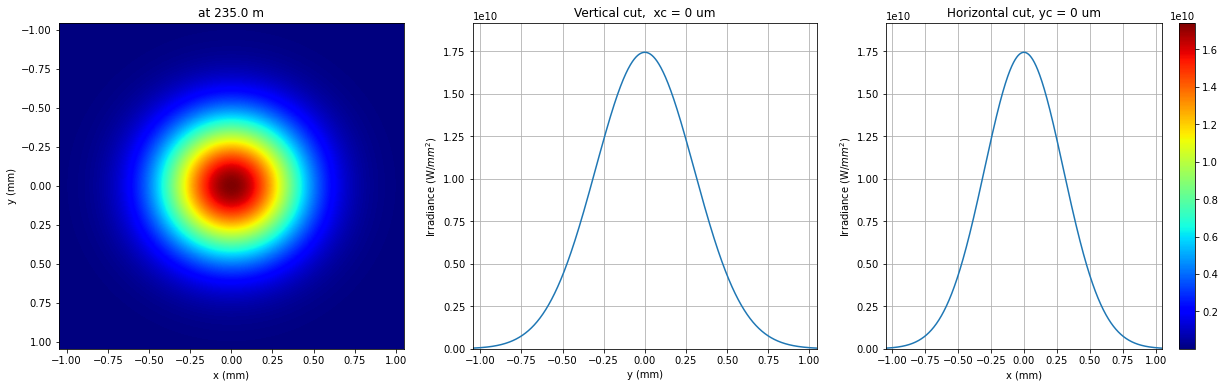

In [126]:
print('*****defining initial wavefront and writing electric field data to h5-file...')
strDataFolderName = 'WPG_output' # output data sub-folder name
if not os.path.exists(strDataFolderName):
    mkdir_p(strDataFolderName)

ekev = 6.742 # Energy [keV]
thetaOM = 2.5e-3       # @check!

# e-bunch charge, [nC]; total pulse energy, J
#qnC = 0.02;pulse_duration = 1.7e-15;pulseEnergy = 0.08e-3
#coh_time = 0.24e-15

qnC = 0.1; # e-bunch charge, [nC]
#pulse_duration = 9.e-15;
pulse_duration = 50.e-15;
pulseEnergy = 0.5e-3; # total pulse energy, J
coh_time = 0.24e-15

''' distance to first OE '''
z1 = 235.0

theta_fwhm = calculate_theta_fwhm_cdr(ekev,qnC)
k = 2*np.sqrt(2*np.log(2))
sigX = 12.4e-10*k/(ekev*4*np.pi*theta_fwhm)
print('sigX, waist_fwhm [um], far field theta_fwhms [urad]: {}, {},{}'.format(
                            sigX*1e6, sigX*k*1e6, theta_fwhm*1e6)
      )
#define limits
range_xy = theta_fwhm/k*z1*7. # sigma*7 beam size

''' input dimensions '''
npoints=2000

wfr0 = build_gauss_wavefront_xy(npoints, npoints, ekev, -range_xy/2, range_xy/2,
                                -range_xy/2, range_xy/2 ,sigX, sigX, z1,
                                pulseEn=pulseEnergy, pulseTau=coh_time/np.sqrt(2),
                                repRate=1/(np.sqrt(2)*pulse_duration))

mwf = Wavefront(wfr0)
ip = np.floor(ekev)
frac = np.floor((ekev - ip)*1e3)
ename = str(int(ip))+'_'+str(int(frac))+'kev'
fname0 = 'g' + ename
ifname = os.path.join(strDataFolderName,fname0+'.h5')
print('save hdf5: '+fname0+'.h5')
mwf.store_hdf5(ifname)
print('done')

pow_x=plot_wfront(mwf, 'at '+str(z1)+' m',False, False, 1e-5,1e-5,'x', True, saveDir='./'+strDataFolderName)
plt.set_cmap('jet') #set color map, 'bone', 'hot', 'jet', etc
plt.colorbar()
plt.savefig('WPG_Plots/Gaussian beam source.png',transparent=True)
fwhm_x = calculate_fwhm_x(mwf);fwhm_y = calculate_fwhm_y(mwf)
print('FWHMx [mm], theta_fwhm=fwhm_x/z1 [urad], distance to waist: {}, {}'.format(
        fwhm_x*1e3,fwhm_x/z1*1e6)
      )

mwf_backup = mwf

In [127]:
print(pow_x[:,1].max())
print ('I_o {} [GW/mm^2]'.format((pow_x[:,1].max()*1e-9)))
print ('peak power {} [GW]'.format((pow_x[:,1].max()*1e-9*1e6*2*np.pi*(fwhm_x/2.35)**2)))

print('{} slices'.format(mwf.params.Mesh.nSlices))

17427292160.0
I_o 17.42729216 [GW/mm^2]
peak power 9.79245924084223 [GW]
1 slices


### Defining optical beamline(s) 

In [133]:
''' crystal parameters '''
d_sp = 3.13557135638           # reflecting plane d-spacing [A]
psi0r = -5.11321939903e-05     # real part of 0th Fourier component of crystal polarizability
psi0i = 3.58887560736e-06      # imaginary part of ""
psi_hr = -2.71341902391e-05    # real part of Hth Fourier component
psi_hi = 2.50565837652e-06     # imaginary part of ""
psi_hbr = -2.71341902391e-05   # real part of -Hth Fourier component
psi_hbi = 2.50565837652e-06    # imaginary part of ""
tc = 0.01                      # crystal thickness
ang_as = -np.deg2rad(5)        # asymmetric angle
uc = 1                         # use case: 1 (Bragg reflection); 2 (Bragg transmission)
#ang = 0.83257236543
#amp_coef = 1.0

OE_Crystal = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as,_uc=uc)

''' crystal orientation '''
ang_dif_pl = 0                # diffraction plane angle: 0 (vertical); pi/2 (horizontal)

# outward normal vector to crystal surface
nvx, nvy, nvz = OE_Crystal.find_orient(ekev*1e3,ang_dif_pl)[0][2]

# central tangential vector
tvx, tvy, _ = OE_Crystal.find_orient(ekev*1e3,ang_dif_pl)[0][0]

OE_Crystal.set_orient(nvx,nvy,nvz,tvx,tvy)

### Propagation

In [134]:
''' Propagation distance '''
z2 = 1

''' WPG '''
optBL0 = Beamline()
optBL0.append(OE_Crystal, Use_PP())
optBL0.append(Drift(z2),  Use_PP(semi_analytical_treatment=1))

optBL = optBL0
bl = optBL

out_file_name = os.path.join(strDataFolderName, 'WPG_Asym_Crystal_bl_{}keV.h5'.format(ekev))
print('save hdf5:'+ out_file_name)

startTime = time.time()
mwf = propagate_wavefront(ifname, bl,out_file_name)
print('propagation lasted: {} min'.format(round((time.time() - startTime) / 6.) / 10.))


save hdf5:WPG_output\WPG_Asym_Crystal_bl_6.742keV.h5
Optical Element: Ideal Crystal
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	angAs = -0.08726646259971647
	aux_ang_dif_pl = 0
	aux_energy = 6742.0
	dSp = 3.13557135638
	nvx = 0
	nvy = 0.9268145503875322
	nvz = -0.3755193592745338
	psi0i = 3.58887560736e-06
	psi0r = -5.11321939903e-05
	psiHbi = 2.50565837652e-06
	psiHbr = -2.71341902391e-05
	psiHi = 2.50565837652e-06
	psiHr = -2.71341902391e-05
	tc = 0.01
	tvx = 0
	tvy = 0.3755193592745338
	uc = 1
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 1
	treat = 0
	

*****reading wavefront from h5 file...
R-space
nx  2000  range_x [-1.0e+00, 1.0e+00] mm
ny  2000  range_y [-1.0e+00, 1.0e+00] mm
*****propagating wavefront (with resizing)...
save hdf5: WPG_output\WPG_Asym_Crystal_bl_6.742keV.h5
done
propagation lasted: 0.1 min


R-space
R-space


"\n# phase plot\n[xmin, xmax, ymin, ymax] = mwf_backup.get_limits()\nplt.figure(figsize=(16,6))\nplt.subplot(1,2,1)\nplt.imshow(mwf_backup.get_phase(slice_number=0),cmap='jet',\n          extent = [xmin*1e3, xmax*1e3, ymin*1e3, ymax*1e3])\nplt.colorbar()\nplt.title('incident Gaussian beam')\nplt.xlabel('x (mm)')\nplt.ylabel('y (mm)')\n\n# reflected beam\n[xmin, xmax, ymin, ymax] = mwf.get_limits()\nplt.subplot(1,2,2)\nplt.imshow(mwf.get_phase(slice_number=0),cmap='jet',\n          extent = [xmin*1e3, xmax*1e3, ymin*1e3, ymax*1e3])\nplt.colorbar()\nplt.title('reflected beam')\nplt.xlabel('x (mm)')\nplt.ylabel('y (mm)')\n"

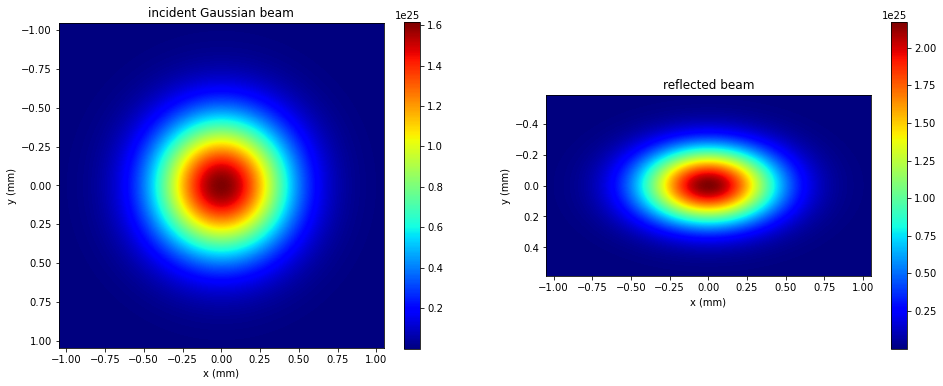

In [135]:
''' plot '''
# incident beam
[xmin, xmax, ymin, ymax] = mwf_backup.get_limits()
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.imshow(mwf_backup.get_intensity(slice_number=0),cmap='jet',
          extent = [xmin*1e3, xmax*1e3, ymin*1e3, ymax*1e3])
plt.colorbar()
plt.title('incident Gaussian beam')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')

# reflected beam
[xmin, xmax, ymin, ymax] = mwf.get_limits()
plt.subplot(1,2,2)
plt.imshow(mwf.get_intensity(slice_number=0),cmap='jet',
          extent = [xmin*1e3, xmax*1e3, ymin*1e3, ymax*1e3])
plt.colorbar()
plt.title('reflected beam')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')

'''
# phase plot
[xmin, xmax, ymin, ymax] = mwf_backup.get_limits()
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.imshow(mwf_backup.get_phase(slice_number=0),cmap='jet',
          extent = [xmin*1e3, xmax*1e3, ymin*1e3, ymax*1e3])
plt.colorbar()
plt.title('incident Gaussian beam')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')

# reflected beam
[xmin, xmax, ymin, ymax] = mwf.get_limits()
plt.subplot(1,2,2)
plt.imshow(mwf.get_phase(slice_number=0),cmap='jet',
          extent = [xmin*1e3, xmax*1e3, ymin*1e3, ymax*1e3])
plt.colorbar()
plt.title('reflected beam')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
'''

R-space


Text(0, 0.5, 'fy')

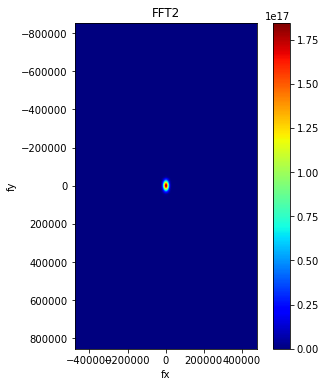

In [136]:
# spatial spectrum
field = mwf.get_real_part(slice_number=0) + 1j * mwf.get_imag_part(slice_number=0)
FFT2 = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(field)))

[xmin, xmax, ymin, ymax] = mwf.get_limits()
dx = (xmax-xmin)/(npoints-1)
dy = (ymax-ymin)/(npoints-1)
fx_max = 1/2/dx
fy_max = 1/2/dy

plt.figure(figsize=(6,6))
plt.imshow(np.abs(FFT2),cmap='jet',
          extent=[-fx_max,fx_max,-fy_max,fy_max])
plt.colorbar()
plt.title('FFT2')
plt.xlabel('fx')
plt.ylabel('fy')

Q-space


Text(0, 0.5, '$\\mu$rad')

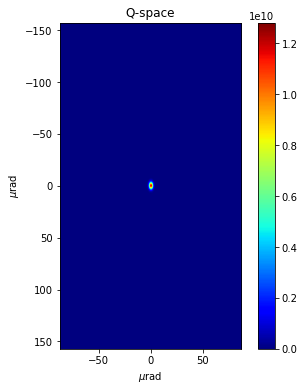

In [137]:
# Q-space
mwf_fft = copy.deepcopy(mwf._srwl_wf)
srwl.SetRepresElecField(mwf_fft,'a')
mwf_fft = Wavefront(mwf_fft)

[Qxmin, Qxmax, Qymin, Qymax] = mwf_fft.get_limits()

plt.figure(figsize=(6,6))
plt.imshow(mwf_fft.get_intensity().sum(axis=-1), cmap='jet',
          extent = [Qxmin*1e6, Qxmax*1e6, Qymin*1e6, Qymax*1e6])
plt.colorbar()
plt.title('Q-space')
plt.xlabel(r'$\mu$rad')
plt.ylabel(r'$\mu$rad')


# Next

Simulate how well can asymmetric crystals focus chirped pulse.

The first challenge is to use chirped pulse as an input.